Hi Jimi, this is Tom Hughes.
My Homework 1 submission is below.
Code is labeled with a comment at the top for which problem it is answering

## HW1.0.0. 

#### Define big data. Provide an example of a big data problem in your domain of expertise.

Big data is data that is large, complex, fast-changing and/or of questionable quality.  This nature means that "traditional" systems (i.e. single machine) are inadequate for reading, analyzing and storing.

#### What is a race condition in the context of parallel computation? Give an example.

A race condition occurs when two+ threads can access shared data and are both trying to change the data at the same time.  This causes issues when 1 thread overwrites a variable that is also used by another thread.
    
    Example:
    Two threads each use the same variable name in different ways:
    thread 1: X = 2X 
    thread 2: X = 3X
    
    Depending on which thread writes to X first, you could get a different answer for what value X equals

#### What is MapReduce?

MapReduce is a programming model to deal with large, complex datasets through the use of a cluster of nodes via a parallel, distributed algorithm.
MapReduce distributes data to different nodes to perform parallel mapping (data splits, filter, sorting, etc).  Once all the mappers are complete (i.e. at the barrier), data is passed to reducer(s) where it is fully consolidated for summary calculations.

#### How does it differ from Hadoop?

MapReduce is a programming model while Hadoop is a distributed file system.  
Hadoop stores the data and provides computational horsepower while 
MapReduce is the program that allows users to analyze and work with the data

## HW1.0.1

#### Which programming paradigm is Hadoop based on? 

Hadoop uses MapReduce

#### Explain and give a simple example of functional programming in raw python code and show the code running. E.g., in raw python find the average length of a string in and of strings using a python "map-reduce" (functional programming) job (similar in style to the above). Alternatively, you can do this in python Hadoop Streaming. 

#### strings = ["str1", "string2", "w261", "MAchine learning at SCALE"]


In [8]:
#Jimi's HW 1.0.1 Example
#EXAMPLE Mapper functions in Python
def fahrenheit(T):
    return ((float(9)/5)*T + 32)

def celsius(T):
    return (float(5)/9)*(T-32)
 
temperatures = (36.5, 37, 37.5, 38, 39)
F = map(fahrenheit, temperatures)
#returns  97.7  98.6  99.5 100.4 102.2
C = map(celsius, F)

print(F)
print(C)

import functools
print "Average temp is %fF" % (functools.reduce(lambda x,y: x+y, F)/len(F) )
#returns Average temp is 99.68F

[97.7, 98.60000000000001, 99.5, 100.4, 102.2]
[36.5, 37.00000000000001, 37.5, 38.00000000000001, 39.0]
Average temp is 99.680000F


In [30]:
#Tom's HW 1.0.1 Submission

#Set the list of strings to what Jimi gave in the example
strings = ["str1", "string2", "w261", "MAchine learning at SCALE"]

#Create a function to simulate the mapper to calculate the length of each individual string in the list
def str_len(X):
    return (len(X))

#Apply the mapper function to the data
Q = map(str_len, strings)

#Show individual string lengths
for i in strings:
    print (str(i) + " length is " + str(len(i)))

import functools    
#Simulate the Reducer by calculating the average string length of the whole list
#The full list could have been spread over multiple mappers, but needs the reducer to do aggregate calculations
print "\n\nAverage string length is %f" % (functools.reduce(lambda x,y: x+y, Q)/len(Q))

str1 length is 4
string2 length is 7
w261 length is 4
MAchine learning at SCALE length is 25


Average string length is 10.000000


## HW1.1 Cross fold validation (*)

#### What is cross validation (in partiticular 10-fold cross validation)?

Cross validation is a way to test your model's error without having a specific test set.
In this validation you partition off some of your training set and use it as a test set.
This allows the model to predict on a set of data it has never seen
    
10-fold cross validation creates 10 such partitions (typically by dividing the whole data set into 10ths)
Then, you can test your model 10 different times, each time holding a different 10% of the data out and 
training on the remaining 90%.  The validation results can then be averaged over the different trials to 
understand model error.


## HW1.2: WORDCOUNT

#### Using the Enron dataset and Hadoop MapReduce streaming (or MRJob), write the mapper/reducer job that  will determine the word count (number of occurrences) of each white-space delimitted token (assume spaces, fullstops, comma as delimiters). Examine the word “assistance” and report its word count results.

#### HW 1.2.1  Using Hadoop MapReduce (or MRJob) and your wordcount job (from HW1.2) determine the top-10 occurring tokens (most frequent tokens) using a single reducer.


In [3]:
%%writefile MRWordCount.py
#HW 1.2

from mrjob.job import MRJob
import sys, re, string, operator


regex = re.compile('[%s]' % re.escape(string.punctuation))

class MRWordCount(MRJob):
    
    def __init__(self, *args, **kwargs):
        super(MRWordCount, self).__init__(*args, **kwargs)
        self.wordcount = {}
    
    def jobconf(self):
        orig_jobconf = super(MRWordCount, self).jobconf()        
        custom_jobconf = {
            'mapred.output.key.comparator.class': 'org.apache.hadoop.mapred.lib.KeyFieldBasedComparator',
            'mapred.text.key.comparator.options': '-k1rn',
            'mapred.reduce.tasks': '1',
        }
        combined_jobconf = orig_jobconf
        combined_jobconf.update(custom_jobconf)
        self.jobconf = combined_jobconf
        return combined_jobconf
        
    def mapper(self, _, line):
        # Don't actually yield anything for each line. Instead, collect them
        # and yield the sums when all lines have been processed. The results
        # will be collected by the reducer.
        
        docID, docClass,text = line.split("\t",2)
        text = text.strip()
        text = regex.sub(' ', text.lower())
        text = re.sub( '\s+', ' ', text )
        words = text.split()
        
        for word in words:
            #if len(word) > 1:  #drop single character words
            yield(word, 1)
        
    def reducer(self, key, values):
        
        for value in values:
            self.wordcount[key] = self.wordcount.get(key, 0) + 1
        yield(key, self.wordcount[key])
        
    def reducer_final(self):
        top_ten = dict(sorted(self.wordcount.iteritems(), key=operator.itemgetter(1), reverse=True)[:10])
        #HW 1.2.1
        print(top_ten)
        """ky, vl = max(self.wordcount.iteritems(), key=lambda x:x[1])
        print (ky, vl)"""
        print(self.wordcount)
        

    

if __name__ == '__main__':
    MRWordCount.run()

Overwriting MRWordCount.py


In [36]:
!python MRWordCount.py  enronemail_1h.txt

{'and': 670, 'a': 543, 'for': 374, 'of': 566, 'your': 395, 'to': 964, 'ect': 382, 'in': 418, 'the': 1247, 'you': 445}
{'stock': 5, 'limited': 14, 'entergyr': 1, 'additionally': 2, 'doubts': 1, 'dynamic': 2, 'externally': 2, 'yellow': 1, 'barraged': 1, 'prefix': 1, '35782': 1, 'invovled': 2, 'railing': 1, 'tuning': 1, 'appetite': 2, 'hate': 4, 'worked': 3, 'forget': 1, 'looking': 4, 'fronts': 1, 'founder': 1, 'granting': 1, 'electricity': 1, 'turner': 3, 'locomotive': 1, '7517': 1, '345': 1, 'ilug': 3, 'koromah': 2, 'swap': 2, 'whatsoever': 3, 'riedel': 1, 'sibilant': 1, 'sorry': 2, 'diverted': 1, 'homemakers': 1, '349': 2, 'overpaying': 1, 'merchant': 5, 'plants': 2, 'etringer': 2, 'collaborate': 3, 'legislators': 2, 'risk': 49, 'taylorja': 1, 'tomorrow': 5, 'regional': 11, 'distort': 1, 'knelt': 1, 'travis': 1, 'shoot': 1, 'georgia': 1, 'every': 14, 'affect': 2, 'multiple': 7, 'four': 8, 'school': 2, 'internally': 2, 'prize': 1, 'exaggerate': 1, 'customizable': 1, 'ref': 2, 'withers':

No configs found; falling back on auto-configuration
Creating temp directory c:\users\z030757\appdata\local\temp\MRWordCount.z030757.20160622.184019.697000
Running step 1 of 1...
Streaming final output from c:\users\z030757\appdata\local\temp\MRWordCount.z030757.20160622.184019.697000\output...
Removing temp directory c:\users\z030757\appdata\local\temp\MRWordCount.z030757.20160622.184019.697000...


In [1]:
!python MRWordCount.py enronemail_1h.txt > grep assistance enronemail_1h.txt|cut -d$'\t' -f4| grep assistance|wc -l

'cut' is not recognized as an internal or external command,
operable program or batch file.


    Looking at the output above, assistance occurs 10 times:  "assistance"	10
    The top row of the output shows the top 10 words and counts.  They are: "the", "to", "and", "of", "a", "you", "your", "in", "ect", "for"

## HW 1.3 Multinomial Naive Bayes with NO smoothing using a single reducer

 #### Using the Enron data from HW1 and Hadoop MapReduce (or MRJob), write  a mapper/reducer job(s) that
   will both learn  Naive Bayes classifier and classify the Enron email messages using the learnt Naive Bayes classifier. Use all white-space delimitted tokens as independent input variables (assume spaces, fullstops, commas as delimiters). Note: for multinomial Naive Bayes, the Pr(X=“assistance”|Y=SPAM) is calculated as follows:

   the number of times “assistance” occurs in SPAM labeled documents / the number of words in documents labeled SPAM 

   E.g.,   “assistance” occurs 5 times in all of the documents Labeled SPAM, and the length in terms of the number of words in all documents labeled as SPAM (when concatenated) is 1,000. Then Pr(X=“assistance”|Y=SPAM) = 5/1000. Note this is a multinomial estimation of the class conditional for a Naive Bayes Classifier. No smoothing is needed in this HW. Multiplying lots of probabilities, which are between 0 and 1, can result in floating-point underflow. Since log(xy) = log(x) + log(y), it is better to perform all computations by summing logs of probabilities rather than multiplying probabilities. Please pay attention to probabilites that are zero! They will need special attention. Count up how many times you need to process a zero probabilty for each class and report. 

   Report the performance of your learnt classifier in terms of misclassifcation error rate of your multinomial Naive Bayes Classifier. Plot a histogram of the  posterior probabilities (i.e., Pr(Class|Doc)) for each class over the training set. Summarize what you see. 

   Error Rate = misclassification rate with respect to a provided set (say training set in this case). It is more formally defined here:

Let DF represent the evalution set in the following:
Err(Model, DF) = |{(X, c(X)) ∈ DF : c(X) != Model(x)}|   / |DF|

Where || denotes set cardinality; c(X) denotes the class of the tuple X in DF; and Model(X) denotes the class inferred by the Model “Model”

NOTE: please assume one reducer.


In [2]:
%%writefile EnronNaiveBayesTrainer.py
#HW 1.3

from mrjob.job import MRJob
import sys, re, string, operator

regex = re.compile('[%s]' % re.escape(string.punctuation))

class EnronNaiveBayesTrainer(MRJob):
    
    def __init__(self, *args, **kwargs):
        super(EnronNaiveBayesTrainer, self).__init__(*args, **kwargs)
        self.modelStats = {}


    def jobconf(self):
        orig_jobconf = super(EnronNaiveBayesTrainer, self).jobconf()        
        custom_jobconf = {
            'mapred.output.key.comparator.class': 'org.apache.hadoop.mapred.lib.KeyFieldBasedComparator',
            'mapred.text.key.comparator.options': '-k1rn',
            'mapred.reduce.tasks': '1',
        }
        combined_jobconf = orig_jobconf
        combined_jobconf.update(custom_jobconf)
        self.jobconf = combined_jobconf
        return combined_jobconf

    def mapper(self, _, line):
        # Don't actually yield anything for each line. Instead, collect them
        # and yield the sums when all lines have been processed. The results
        # will be collected by the reducer.
        docID, docClass,text = line.split("\t",2) 
        text = text.strip()
        text = regex.sub(' ', text.lower())
        text = re.sub( '\s+', ' ', text )
        words = text.split()
        
        if docClass == "1":
            yield("TomsPriors", "0,1")
            for word in words:
                yield(word, "0,1")
        else:
            yield("TomsPriors", "1,0")
            for word in words:
                yield(word, "1,0")
        

    def reducer(self, word, values):
        #aggregate counts for Pr(Word|Class)
        #yield("number of values for "+word, str(values))
        w0Total=0
        w1Total=0
        for value in values:
            w0, w1 =  value.split(",")
            w0Total += float(w0)
            w1Total += float(w1)  
        self.modelStats[word] =  [w0Total, w1Total]

        #yield("JIMI "+word, [w0Total, w1Total])
    def reducer_final(self):       
        class0Total = 0
        class1Total = 0
        for k in self.modelStats.keys():
            if k != "TomsPriors":
                class0Total += self.modelStats[k][0]
                class1Total += self.modelStats[k][1]
        vocabularySize = len(self.modelStats.keys()) -1  #ignore TomsPriors
        #some yields to see some model internal parameters
        #yield ("defaultPrior 0 class", class0Total+vocabularySize)
        #yield ("defaultPrior 1 class", class1Total+vocabularySize)
        #yield ("count 0 class", class0Total)
        #yield ("count 1 class", class1Total)
        #yield ("vocabularySize", vocabularySize)
        
        #calculate priors 
        classCount0, classCount1 = self.modelStats.get("TomsPriors")
        del self.modelStats["TomsPriors"]
        total = classCount0 + classCount1
        yield("TomsPriors", ','.join(str(j) for j in [classCount0, classCount1, classCount0/total, classCount1/total])) 
        for k in self.modelStats.keys():
            yield(k, ','.join(str(j) for j in [self.modelStats[k][0],
                      self.modelStats[k][1],
                      self.modelStats[k][0] / class0Total,   
                      self.modelStats[k][1] / class1Total]))                         
                      # smoothing (self.modelStats[k][0] + 1) /(class0Total + vocabularySize), 
                      # smoothing (self.modelStats[k][1] +1)/(class1Total+vocabularySize)]))
                            
        #print(self.modelStats["assistance"])
        #print(vocabularySize)
        #print(class0Total, class1Total)
# The if __name__ == "__main__": 
# ... trick exists in Python so that our Python files 
# can act as either reusable modules, or as standalone programs.

if __name__ == '__main__':
    EnronNaiveBayesTrainer.run(),
                                               

Overwriting EnronNaiveBayesTrainer.py


In [1]:
!python EnronNaiveBayesTrainer.py  enronemail_1h.txt

"TomsPriors"	"56.0,44.0,0.56,0.44"
"stock"	"3.0,2.0,0.000209555741827,0.000105892942235"
"limited"	"4.0,10.0,0.00027940765577,0.000529464711177"
"entergyr"	"1.0,0.0,6.98519139424e-05,0.0"
"additionally"	"1.0,1.0,6.98519139424e-05,5.29464711177e-05"
"doubts"	"0.0,1.0,0.0,5.29464711177e-05"
"dynamic"	"2.0,0.0,0.000139703827885,0.0"
"externally"	"0.0,2.0,0.0,0.000105892942235"
"yellow"	"0.0,1.0,0.0,5.29464711177e-05"
"barraged"	"0.0,1.0,0.0,5.29464711177e-05"
"prefix"	"0.0,1.0,0.0,5.29464711177e-05"
"35782"	"1.0,0.0,6.98519139424e-05,0.0"
"invovled"	"2.0,0.0,0.000139703827885,0.0"
"railing"	"0.0,1.0,0.0,5.29464711177e-05"
"tuning"	"1.0,0.0,6.98519139424e-05,0.0"
"appetite"	"0.0,2.0,0.0,0.000105892942235"
"hate"	"0.0,4.0,0.0,0.000211785884471"
"worked"	"1.0,2.0,6.98519139424e-05,0.000105892942235"
"forget"	"0.0,1.0,0.0,5.29464711177e-05"
"looking"	"0.0,4.0,0.0,0.000211785884471"
"fronts"	"1.0,0.0,6.98519139424e-05,0.0"
"founder"	"0.0,1.0,0.0,5.29464711177e-05"
"granting"	"0.0,1.0,0.0,5.294

No configs found; falling back on auto-configuration
Creating temp directory c:\users\z030757\appdata\local\temp\EnronNaiveBayesTrainer.z030757.20160623.173025.419000
Running step 1 of 1...
Streaming final output from c:\users\z030757\appdata\local\temp\EnronNaiveBayesTrainer.z030757.20160623.173025.419000\output...
Removing temp directory c:\users\z030757\appdata\local\temp\EnronNaiveBayesTrainer.z030757.20160623.173025.419000...


In [4]:
#------------------------------------------------------------------------------------
# We have two ways to run the Naive Bayes algorithm
# 1. Run using the command line (shown Above)
# 2. Run using a MRJob Runner from python (very sweet way to do business). See Here
#------------------------------------------------------------------------------------
#HW 1.3
%reload_ext autoreload
%autoreload 2

from numpy import random
from EnronNaiveBayesTrainer import EnronNaiveBayesTrainer 

# STEP 1: Train a mulitnomial Naive Bayes      
trainingData = 'enronemail_1h.txt'

# create an instance of the Trainer class
# and initiatialize it
mr_job = EnronNaiveBayesTrainer(args=[trainingData])
modelStats={}
with mr_job.make_runner() as runner: 
    runner.run()
    # stream_output: get access to the output reducer/reducer_final of 
    # the last step in MRNaiveBayesTrainer
    for line in runner.stream_output():
        key,value =  mr_job.parse_output_line(line)
        print key, value
        modelStats[key] = value            
    # Store model locally
    with open('EnronModel1.txt', 'w') as f:
        for k in modelStats.keys():
            f.writelines( k + "\t"+ str(modelStats[k]) +"\n")
print modelStats

TomsPriors 56.0,44.0,0.56,0.44
stock 3.0,2.0,0.000209555741827,0.000105892942235
limited 4.0,10.0,0.00027940765577,0.000529464711177
entergyr 1.0,0.0,6.98519139424e-05,0.0
additionally 1.0,1.0,6.98519139424e-05,5.29464711177e-05
doubts 0.0,1.0,0.0,5.29464711177e-05
dynamic 2.0,0.0,0.000139703827885,0.0
externally 0.0,2.0,0.0,0.000105892942235
yellow 0.0,1.0,0.0,5.29464711177e-05
barraged 0.0,1.0,0.0,5.29464711177e-05
prefix 0.0,1.0,0.0,5.29464711177e-05
35782 1.0,0.0,6.98519139424e-05,0.0
invovled 2.0,0.0,0.000139703827885,0.0
railing 0.0,1.0,0.0,5.29464711177e-05
tuning 1.0,0.0,6.98519139424e-05,0.0
appetite 0.0,2.0,0.0,0.000105892942235
hate 0.0,4.0,0.0,0.000211785884471
worked 1.0,2.0,6.98519139424e-05,0.000105892942235
forget 0.0,1.0,0.0,5.29464711177e-05
looking 0.0,4.0,0.0,0.000211785884471
fronts 1.0,0.0,6.98519139424e-05,0.0
founder 0.0,1.0,0.0,5.29464711177e-05
granting 0.0,1.0,0.0,5.29464711177e-05
electricity 1.0,0.0,6.98519139424e-05,0.0
turner 1.0,2.0,6.98519139424e-05,0.0

In [119]:
%%writefile EnronNaiveBayesClassifier.py
#HW 1.3
 
from mrjob.job import MRJob
import sys, re, string, operator, math, os


regex = re.compile('[%s]' % re.escape(string.punctuation))

class EnronNaiveBayesClassifier(MRJob):


    def __init__(self, *args, **kwargs):
        super(EnronNaiveBayesClassifier, self).__init__(*args, **kwargs)
        self.zeroProb = 0

    def jobconf(self):
        orig_jobconf = super(EnronNaiveBayesClassifier, self).jobconf()        
        custom_jobconf = {
            'mapred.output.key.comparator.class': 'org.apache.hadoop.mapred.lib.KeyFieldBasedComparator',
            'mapred.text.key.comparator.options': '-k1rn',
            'mapred.reduce.tasks': '1',
        }
        combined_jobconf = orig_jobconf
        combined_jobconf.update(custom_jobconf)
        self.jobconf = combined_jobconf
        return combined_jobconf    

    #load model from file; it has been sent from the master node to each worker node
    def mapper_init(self):
        self.modelStats = {}
        
        recordStrs = [s.split('\n')[0].split('\t') for s in open("EnronModel1.txt").readlines()]
        for word, statsStr in recordStrs:
            self.modelStats[word] = map(float, statsStr.split(","))
        
        self.prC0 = math.log(self.modelStats["TomsPriors"][2])
        self.prC1 = math.log(self.modelStats["TomsPriors"][3])
        

    
    def mapper(self, _, line):
        
        docID, docClass,text = line.split("\t",2)
        text = text.strip()
        text = regex.sub(' ', text.lower())
        text = re.sub( '\s+', ' ', text )
        words = text.split()
        
        for word in words:
            p0 = self.modelStats[word][2]
            if self.modelStats[word][2] == 0.0:
                self.zeroProb += 1
            p1 = self.modelStats[word][3]
            if self.modelStats[word][3] == 0.0:
                self.zeroProb += 1
            wordGivenHam = math.log(p0) if p0>0.0 else math.log(1)
            wordGivenSpam = math.log(p1) if p1>0.0 else math.log(1)
            prHAMGivenDoc = self.prC0 + wordGivenHam
            prSPAMGivenDoc = self.prC1 + wordGivenSpam
        
        predictedClass = 1 #SPAM
        if(prHAMGivenDoc > prSPAMGivenDoc):
            predictedClass = 0 #HAM
        if int(docClass) == predictedClass:
            yield (docID, 0)  #no error
        else: 
            yield (docID, 1) # error    
        yield("zero", self.zeroProb)
    
    def combiner(self, word, values):
        for value in values:
            yield ("t", value)
            
    def reducer(self, word, values):
        zero = 0
        numberOfRecords = 0
        numberWrong = 0
        for value in values:
            if value > 1:
                zero = value
            else:    
                numberOfRecords += 1
                numberWrong += value
        #print (numberOfRecords, numberWrong)
        print ('Error rate: %.4f' %(1.0*numberWrong/float(numberOfRecords)))
        print ('Number Wrong %d, Total Records %d'  %(numberWrong, numberOfRecords))
        print ('number of word|class with 0 probability: %d' %(zero))



if __name__ == '__main__':
    EnronNaiveBayesClassifier.run()



Overwriting EnronNaiveBayesClassifier.py


In [120]:
!python EnronNaiveBayesClassifier.py --jobconf mapred.reduce.tasks=1 enronemail_1h.txt --file=EnronModel1.txt

Error rate: 0.7600
Number Wrong 76, Total Records 100
number of word|class with 0 probability: 991


No configs found; falling back on auto-configuration
Creating temp directory c:\users\z030757\appdata\local\temp\EnronNaiveBayesClassifier.z030757.20160624.192612.505000
Running step 1 of 1...
Streaming final output from c:\users\z030757\appdata\local\temp\EnronNaiveBayesClassifier.z030757.20160624.192612.505000\output...
Removing temp directory c:\users\z030757\appdata\local\temp\EnronNaiveBayesClassifier.z030757.20160624.192612.505000...


## 1.4.0 Multinomial Naive Bayes with Smoothing

#### Repeat HW1.3 with the following modification: use Laplace plus-one smoothing. Compare the misclassifcation error rates for HW1.3 versus HW1.4 and explain the differences.

In [5]:
%%writefile EnronNaiveBayesTrainerLaplace.py
#HW 1.4.0

from mrjob.job import MRJob
import sys, re, string, operator

regex = re.compile('[%s]' % re.escape(string.punctuation))

class EnronNaiveBayesTrainerLaplace(MRJob):
    
    def __init__(self, *args, **kwargs):
        super(EnronNaiveBayesTrainerLaplace, self).__init__(*args, **kwargs)
        self.modelStats = {}

    def jobconf(self):
        orig_jobconf = super(EnronNaiveBayesTrainerLaplace, self).jobconf()        
        custom_jobconf = {
            'mapred.output.key.comparator.class': 'org.apache.hadoop.mapred.lib.KeyFieldBasedComparator',
            'mapred.text.key.comparator.options': '-k1rn',
            'mapred.reduce.tasks': '1',
        }
        combined_jobconf = orig_jobconf
        combined_jobconf.update(custom_jobconf)
        self.jobconf = combined_jobconf
        return combined_jobconf

    def mapper(self, _, line):
        # Don't actually yield anything for each line. Instead, collect them
        # and yield the sums when all lines have been processed. The results
        # will be collected by the reducer.
        docID, docClass,text = line.split("\t",2) 
        text = text.strip()
        text = regex.sub(' ', text.lower())
        text = re.sub( '\s+', ' ', text )
        words = text.split()
        
        if docClass == "1":
            yield("TomsPriors", "0,1")
            for word in words:
                yield(word, "0,1")
        else:
            yield("TomsPriors", "1,0")
            for word in words:
                yield(word, "1,0")
        

    def reducer(self, word, values):
        #aggregate counts for Pr(Word|Class)
        #yield("number of values for "+word, str(values))
        w0Total=0
        w1Total=0
        for value in values:
            w0, w1 =  value.split(",")
            w0Total += float(w0)
            w1Total += float(w1)  
        self.modelStats[word] =  [w0Total, w1Total]

        #yield("JIMI "+word, [w0Total, w1Total])
    def reducer_final(self):       
        class0Total = 0
        class1Total = 0
        for k in self.modelStats.keys():
            if k != "TomsPriors":
                class0Total += self.modelStats[k][0]
                class1Total += self.modelStats[k][1]
        vocabularySize = len(self.modelStats.keys()) -1  #ignore TomsPriors
        #some yields to see some model internal parameters
        #yield ("defaultPrior 0 class", class0Total+vocabularySize)
        #yield ("defaultPrior 1 class", class1Total+vocabularySize)
        #yield ("count 0 class", class0Total)
        #yield ("count 1 class", class1Total)
        #yield ("vocabularySize", vocabularySize)
        
        #calculate priors 
        classCount0, classCount1 = self.modelStats.get("TomsPriors")
        del self.modelStats["TomsPriors"]
        total = classCount0 + classCount1
        yield("TomsPriors", ','.join(str(j) for j in [classCount0, classCount1, classCount0/total, classCount1/total])) 
        for k in self.modelStats.keys():
            yield(k, ','.join(str(j) for j in [self.modelStats[k][0],
                      self.modelStats[k][1],                       
                      (self.modelStats[k][0] + 1) /(class0Total + vocabularySize), 
                      (self.modelStats[k][1] +1)/(class1Total+vocabularySize)]))
                            
        #print(self.modelStats["assistance"])
        #print(vocabularySize)
        #print(class0Total, class1Total)
# The if __name__ == "__main__": 
# ... trick exists in Python so that our Python files 
# can act as either reusable modules, or as standalone programs.

if __name__ == '__main__':
    EnronNaiveBayesTrainerLaplace.run(),
                                               

Overwriting EnronNaiveBayesTrainerLaplace.py


In [122]:
!python EnronNaiveBayesTrainerLaplace.py  enronemail_1h.txt

"TomsPriors"	"56.0,44.0,0.56,0.44"
"stock"	"3.0,2.0,0.000202798620969,0.000123482197983"
"limited"	"4.0,10.0,0.000253498276212,0.000452768059271"
"entergyr"	"1.0,0.0,0.000101399310485,4.1160732661e-05"
"additionally"	"1.0,1.0,0.000101399310485,8.23214653221e-05"
"doubts"	"0.0,1.0,5.06996552423e-05,8.23214653221e-05"
"dynamic"	"2.0,0.0,0.000152098965727,4.1160732661e-05"
"externally"	"0.0,2.0,5.06996552423e-05,0.000123482197983"
"yellow"	"0.0,1.0,5.06996552423e-05,8.23214653221e-05"
"barraged"	"0.0,1.0,5.06996552423e-05,8.23214653221e-05"
"prefix"	"0.0,1.0,5.06996552423e-05,8.23214653221e-05"
"35782"	"1.0,0.0,0.000101399310485,4.1160732661e-05"
"invovled"	"2.0,0.0,0.000152098965727,4.1160732661e-05"
"railing"	"0.0,1.0,5.06996552423e-05,8.23214653221e-05"
"tuning"	"1.0,0.0,0.000101399310485,4.1160732661e-05"
"appetite"	"0.0,2.0,5.06996552423e-05,0.000123482197983"
"hate"	"0.0,4.0,5.06996552423e-05,0.000205803663305"
"worked"	"1.0,2.0,0.000101399310485,0.000123482197983"
"forget"	"0.0,1.0

No configs found; falling back on auto-configuration
Creating temp directory c:\users\z030757\appdata\local\temp\EnronNaiveBayesTrainerLaplace.z030757.20160622.201017.132000
Running step 1 of 1...
Streaming final output from c:\users\z030757\appdata\local\temp\EnronNaiveBayesTrainerLaplace.z030757.20160622.201017.132000\output...
Removing temp directory c:\users\z030757\appdata\local\temp\EnronNaiveBayesTrainerLaplace.z030757.20160622.201017.132000...


In [123]:
#------------------------------------------------------------------------------------
# We have two ways to run the Naive Bayes algorithm
# 1. Run using the command line (shown Above)
# 2. Run using a MRJob Runner from python (very sweet way to do business). See Here
#------------------------------------------------------------------------------------
#HW 1.4.0
%reload_ext autoreload
%autoreload 2

from numpy import random
from EnronNaiveBayesTrainerLaplace import EnronNaiveBayesTrainerLaplace 

# STEP 1: Train a mulitnomial Naive Bayes      
trainingData = 'enronemail_1h.txt'

# create an instance of the Trainer class
# and initiatialize it
mr_job = EnronNaiveBayesTrainerLaplace(args=[trainingData])
modelStats={}
with mr_job.make_runner() as runner: 
    runner.run()
    # stream_output: get access to the output reducer/reducer_final of 
    # the last step in MRNaiveBayesTrainer
    for line in runner.stream_output():
        key,value =  mr_job.parse_output_line(line)
        print key, value
        modelStats[key] = value            
    # Store model locally
    with open('EnronModelLaplace.txt', 'w') as f:
        for k in modelStats.keys():
            f.writelines( k + "\t"+ str(modelStats[k]) +"\n")
print modelStats

TomsPriors 56.0,44.0,0.56,0.44
stock 3.0,2.0,0.000202798620969,0.000123482197983
limited 4.0,10.0,0.000253498276212,0.000452768059271
entergyr 1.0,0.0,0.000101399310485,4.1160732661e-05
additionally 1.0,1.0,0.000101399310485,8.23214653221e-05
doubts 0.0,1.0,5.06996552423e-05,8.23214653221e-05
dynamic 2.0,0.0,0.000152098965727,4.1160732661e-05
externally 0.0,2.0,5.06996552423e-05,0.000123482197983
yellow 0.0,1.0,5.06996552423e-05,8.23214653221e-05
barraged 0.0,1.0,5.06996552423e-05,8.23214653221e-05
prefix 0.0,1.0,5.06996552423e-05,8.23214653221e-05
35782 1.0,0.0,0.000101399310485,4.1160732661e-05
invovled 2.0,0.0,0.000152098965727,4.1160732661e-05
railing 0.0,1.0,5.06996552423e-05,8.23214653221e-05
tuning 1.0,0.0,0.000101399310485,4.1160732661e-05
appetite 0.0,2.0,5.06996552423e-05,0.000123482197983
hate 0.0,4.0,5.06996552423e-05,0.000205803663305
worked 1.0,2.0,0.000101399310485,0.000123482197983
forget 0.0,1.0,5.06996552423e-05,8.23214653221e-05
looking 0.0,4.0,5.06996552423e-05,0.00

In [6]:
%%writefile EnronNaiveBayesClassifierLaplace.py
#HW 1.4.0
 
from mrjob.job import MRJob
import sys, re, string, operator, math, os


regex = re.compile('[%s]' % re.escape(string.punctuation))

class EnronNaiveBayesClassifierLaplace(MRJob):


    def __init__(self, *args, **kwargs):
        super(EnronNaiveBayesClassifierLaplace, self).__init__(*args, **kwargs)
        
    def jobconf(self):
        orig_jobconf = super(EnronNaiveBayesClassifierLaplace, self).jobconf()        
        custom_jobconf = {
            'mapred.output.key.comparator.class': 'org.apache.hadoop.mapred.lib.KeyFieldBasedComparator',
            'mapred.text.key.comparator.options': '-k1rn',
            'mapred.reduce.tasks': '1',
        }
        combined_jobconf = orig_jobconf
        combined_jobconf.update(custom_jobconf)
        self.jobconf = combined_jobconf
        return combined_jobconf    

    #load model from file; it has been sent from the master node to each worker node
    def mapper_init(self):
        self.modelStats = {}
        recordStrs = [s.split('\n')[0].split('\t') for s in open("EnronModelLaplace.txt").readlines()]
        for word, statsStr in recordStrs:
            self.modelStats[word] = map(float, statsStr.split(","))
        
        self.prC0 = math.log(self.modelStats["TomsPriors"][2])
        self.prC1 = math.log(self.modelStats["TomsPriors"][3])
        

    
    def mapper(self, _, line):
        
        docID, docClass,text = line.split("\t",2)
        text = text.strip()
        text = regex.sub(' ', text.lower())
        text = re.sub( '\s+', ' ', text )
        words = text.split()
        
        for word in words:
            p0 = self.modelStats[word][2]
            p1 = self.modelStats[word][3]
            wordGivenHam = math.log(p0) if p0>0.0 else math.log(1)
            wordGivenSpam = math.log(p1) if p1>0.0 else math.log(1)
            prHAMGivenDoc = self.prC0 + wordGivenHam
            prSPAMGivenDoc = self.prC1 + wordGivenSpam
        
        predictedClass = 1 #SPAM
        if(prHAMGivenDoc > prSPAMGivenDoc):
            predictedClass = 0 #HAM
        if int(docClass) == predictedClass:
            yield (docID, 0)  #no error
        else: 
            yield (docID, 1) # error    
     
    def combiner(self, word, values):
        for value in values:
            yield ("t", value)
            
    def reducer(self, word, values):      
        numberOfRecords = 0
        numberWrong = 0
        for value in values:
            numberOfRecords += 1
            numberWrong += value
        #print (numberOfRecords, numberWrong)
        print ('Error rate: %.4f' %(1.0*numberWrong/float(numberOfRecords)))
        print ('Number Wrong %d, Total Records %d'  %(numberWrong, numberOfRecords))
        



if __name__ == '__main__':
    EnronNaiveBayesClassifierLaplace.run()



Overwriting EnronNaiveBayesClassifierLaplace.py


In [7]:
!python EnronNaiveBayesClassifierLaplace.py --jobconf mapred.reduce.tasks=1 enronemail_1h.txt --file=EnronModelLaplace.txt

Error rate: 0.1400
Number Wrong 14, Total Records 100


No configs found; falling back on auto-configuration
Creating temp directory c:\users\z030757\appdata\local\temp\EnronNaiveBayesClassifierLaplace.z030757.20160623.173400.778000
Running step 1 of 1...
Streaming final output from c:\users\z030757\appdata\local\temp\EnronNaiveBayesClassifierLaplace.z030757.20160623.173400.778000\output...
Removing temp directory c:\users\z030757\appdata\local\temp\EnronNaiveBayesClassifierLaplace.z030757.20160623.173400.778000...


The mis-classification rate of non-smoothed Naive Bayes on the Enron sample data is 76% versus 14% when Laplace smoothing is applied.  Since there are so many words that do not occur in the spam or ham classes, smoothing helps assign those words a very low probability, which is better than ignoring the words at all

## HW 1.4.1 Jelinek-Mercer (JM) smoothing*

## Repeat HW 1.4.0 with Jelinek-Mercer (JM) smoothing. Present a nice table comparing results where each row is the approach taken (Multinomial Naive Bayes with Laplace+1, or Multinomial Naive Bayes with JM) and the column is error rate.


In [7]:
%%writefile EnronNaiveBayesTrainerJM.py
#HW1.4.1

from mrjob.job import MRJob
import sys, re, string, operator

regex = re.compile('[%s]' % re.escape(string.punctuation))

class EnronNaiveBayesTrainerJM(MRJob):
    
    def __init__(self, *args, **kwargs):
        super(EnronNaiveBayesTrainerJM, self).__init__(*args, **kwargs)
        self.modelStats = {}

    def jobconf(self):
        orig_jobconf = super(EnronNaiveBayesTrainerJM, self).jobconf()        
        custom_jobconf = {
            'mapred.output.key.comparator.class': 'org.apache.hadoop.mapred.lib.KeyFieldBasedComparator',
            'mapred.text.key.comparator.options': '-k1rn',
            'mapred.reduce.tasks': '1',
        }
        combined_jobconf = orig_jobconf
        combined_jobconf.update(custom_jobconf)
        self.jobconf = combined_jobconf
        return combined_jobconf

    def mapper(self, _, line):
        # Don't actually yield anything for each line. Instead, collect them
        # and yield the sums when all lines have been processed. The results
        # will be collected by the reducer.
        docID, docClass,text = line.split("\t",2) 
        text = text.strip()
        text = regex.sub(' ', text.lower())
        text = re.sub( '\s+', ' ', text )
        words = text.split()
        
        if docClass == "1":
            yield("TomsPriors", "0,1")
            for word in words:
                yield(word, "0,1")
        else:
            yield("TomsPriors", "1,0")
            for word in words:
                yield(word, "1,0")
        

    def reducer(self, word, values):
        #aggregate counts for Pr(Word|Class)
        #yield("number of values for "+word, str(values))
        w0Total=0
        w1Total=0
        for value in values:
            w0, w1 =  value.split(",")
            w0Total += float(w0)
            w1Total += float(w1)  
        self.modelStats[word] =  [w0Total, w1Total]

        #yield("JIMI "+word, [w0Total, w1Total])
    def reducer_final(self):       
        class0Total = 0
        class1Total = 0
        JM = .3
        for k in self.modelStats.keys():
            if k != "TomsPriors":
                class0Total += self.modelStats[k][0]
                class1Total += self.modelStats[k][1]
        vocabularySize = len(self.modelStats.keys()) -1  #ignore TomsPriors
        #some yields to see some model internal parameters
        #yield ("defaultPrior 0 class", class0Total+vocabularySize)
        #yield ("defaultPrior 1 class", class1Total+vocabularySize)
        #yield ("count 0 class", class0Total)
        #yield ("count 1 class", class1Total)
        #yield ("vocabularySize", vocabularySize)
        print(class0Total, class1Total)
        #calculate priors 
        classCount0, classCount1 = self.modelStats.get("TomsPriors")
        del self.modelStats["TomsPriors"]
        total = classCount0 + classCount1
        yield("TomsPriors", ','.join(str(j) for j in [classCount0, classCount1, classCount0/total, classCount1/total])) 
        for k in self.modelStats.keys():
            yield(k, ','.join(str(j) for j in [self.modelStats[k][0],
                      self.modelStats[k][1],                       
                      (((1-JM)*(self.modelStats[k][0]/class0Total)) + (JM *(self.modelStats[k][0] + self.modelStats[k][1])/(class0Total + class1Total))), 
                      (((1-JM)*(self.modelStats[k][1]/class1Total)) + JM *(self.modelStats[k][0] + self.modelStats[k][1])/(class0Total + class1Total))]))
                            
        #print(self.modelStats["assistance"])
        #print(vocabularySize)
        
# The if __name__ == "__main__": 
# ... trick exists in Python so that our Python files 
# can act as either reusable modules, or as standalone programs.

if __name__ == '__main__':
    EnronNaiveBayesTrainerJM.run(),
                                               

Overwriting EnronNaiveBayesTrainerJM.py


In [8]:
#------------------------------------------------------------------------------------
# We have two ways to run the Naive Bayes algorithm
# 1. Run using the command line (shown Above)
# 2. Run using a MRJob Runner from python (very sweet way to do business). See Here
#------------------------------------------------------------------------------------
#HW 1.4.1
%reload_ext autoreload
%autoreload 2

from numpy import random
from EnronNaiveBayesTrainerJM import EnronNaiveBayesTrainerJM 

# STEP 1: Train a mulitnomial Naive Bayes      
trainingData = 'enronemail_1h.txt'

# create an instance of the Trainer class
# and initiatialize it
mr_job = EnronNaiveBayesTrainerJM(args=[trainingData])
modelStats={}
with mr_job.make_runner() as runner: 
    runner.run()
    # stream_output: get access to the output reducer/reducer_final of 
    # the last step in MRNaiveBayesTrainer
    for line in runner.stream_output():
        key,value =  mr_job.parse_output_line(line)
        print key, value
        modelStats[key] = value            
    # Store model locally
    with open('EnronModelJM.txt', 'w') as f:
        for k in modelStats.keys():
            f.writelines( k + "\t"+ str(modelStats[k]) +"\n")
print modelStats

(14316.0, 18887.0)
TomsPriors 56.0,44.0,0.56,0.44
stock 3.0,2.0,0.000191865659944,0.00011930170023
limited 4.0,10.0,0.000322079952901,0.000497119891686
entergyr 1.0,0.0,5.79316678927e-05,9.035328133e-06
additionally 1.0,1.0,6.69669960257e-05,5.51331860484e-05
doubts 0.0,1.0,9.035328133e-06,4.60978579154e-05
dynamic 2.0,0.0,0.000115863335785,1.8070656266e-05
externally 0.0,2.0,1.8070656266e-05,9.21957158308e-05
yellow 0.0,1.0,9.035328133e-06,4.60978579154e-05
barraged 0.0,1.0,9.035328133e-06,4.60978579154e-05
prefix 0.0,1.0,9.035328133e-06,4.60978579154e-05
35782 1.0,0.0,5.79316678927e-05,9.035328133e-06
invovled 2.0,0.0,0.000115863335785,1.8070656266e-05
railing 0.0,1.0,9.035328133e-06,4.60978579154e-05
tuning 1.0,0.0,5.79316678927e-05,9.035328133e-06
appetite 0.0,2.0,1.8070656266e-05,9.21957158308e-05
hate 0.0,4.0,3.6141312532e-05,0.000184391431662
worked 1.0,2.0,7.60023241587e-05,0.000101231043964
forget 0.0,1.0,9.035328133e-06,4.60978579154e-05
looking 0.0,4.0,3.6141312532e-05,0.000

In [9]:
%%writefile EnronNaiveBayesClassifierJM.py
#HW 1.4.1
 
from mrjob.job import MRJob
import sys, re, string, operator, math, os


regex = re.compile('[%s]' % re.escape(string.punctuation))

class EnronNaiveBayesClassifierJM(MRJob):


    def __init__(self, *args, **kwargs):
        super(EnronNaiveBayesClassifierJM, self).__init__(*args, **kwargs)
        
    def jobconf(self):
        orig_jobconf = super(EnronNaiveBayesClassifierJM, self).jobconf()        
        custom_jobconf = {
            'mapred.output.key.comparator.class': 'org.apache.hadoop.mapred.lib.KeyFieldBasedComparator',
            'mapred.text.key.comparator.options': '-k1rn',
            'mapred.reduce.tasks': '1',
        }
        combined_jobconf = orig_jobconf
        combined_jobconf.update(custom_jobconf)
        self.jobconf = combined_jobconf
        return combined_jobconf    

    #load model from file; it has been sent from the master node to each worker node
    def mapper_init(self):
        self.modelStats = {}
        recordStrs = [s.split('\n')[0].split('\t') for s in open("EnronModelJM.txt").readlines()]
        for word, statsStr in recordStrs:
            self.modelStats[word] = map(float, statsStr.split(","))
        
        self.prC0 = math.log(self.modelStats["TomsPriors"][2])
        self.prC1 = math.log(self.modelStats["TomsPriors"][3])
        

    
    def mapper(self, _, line):
        
        docID, docClass,text = line.split("\t",2)
        text = text.strip()
        text = regex.sub(' ', text.lower())
        text = re.sub( '\s+', ' ', text )
        words = text.split()
        
        for word in words:
            p0 = self.modelStats[word][2]
            p1 = self.modelStats[word][3]
            wordGivenHam = math.log(p0) if p0>0.0 else math.log(1)
            wordGivenSpam = math.log(p1) if p1>0.0 else math.log(1)
            prHAMGivenDoc = self.prC0 + wordGivenHam
            prSPAMGivenDoc = self.prC1 + wordGivenSpam
        
        predictedClass = 1 #SPAM
        if(prHAMGivenDoc > prSPAMGivenDoc):
            predictedClass = 0 #HAM
        if int(docClass) == predictedClass:
            yield (docID, 0)  #no error
        else: 
            yield (docID, 1) # error    
     
    def combiner(self, word, values):
        for value in values:
            yield ("t", value)
            
    def reducer(self, word, values):      
        numberOfRecords = 0
        numberWrong = 0
        for value in values:
            numberOfRecords += 1
            numberWrong += value
        #print (numberOfRecords, numberWrong)
        print ('Error rate: %.4f' %(1.0*numberWrong/float(numberOfRecords)))
        print ('Number Wrong %d, Total Records %d'  %(numberWrong, numberOfRecords))
        



if __name__ == '__main__':
    EnronNaiveBayesClassifierJM.run()



Overwriting EnronNaiveBayesClassifierJM.py


In [8]:
!python EnronNaiveBayesClassifierJM.py --jobconf mapred.reduce.tasks=1 enronemail_1h.txt --file=EnronModelJM.txt

Error rate: 0.1300
Number Wrong 13, Total Records 100


No configs found; falling back on auto-configuration
Creating temp directory c:\users\z030757\appdata\local\temp\EnronNaiveBayesClassifierJM.z030757.20160623.173432.351000
Running step 1 of 1...
Streaming final output from c:\users\z030757\appdata\local\temp\EnronNaiveBayesClassifierJM.z030757.20160623.173432.351000\output...
Removing temp directory c:\users\z030757\appdata\local\temp\EnronNaiveBayesClassifierJM.z030757.20160623.173432.351000...


## HW1.4.2 Split data in to training, validation and testing data subsets

#### Split the data using MRJob into three subsets in the following proportions (70% for training, 15% for valdiation, and 15% for testing). Train Multinomial Naive Bayes classifiers using Laplace plus-one smoothing and using  Jelinek-Mercer (JM) smoothing where you consider different hyperparameter values for λ. Please consider λ in {0.0, 0.1, 0.3, 0.5, 0.7, 1}. Present  a table compare the  results of the different approaches: each  row is the approach taken (e.g., Multinomial Naive Bayes with Laplace+1, or Multinomial Naive Bayes with  with JM= 0.3 for λ =0.3) and a column for  error rate on the training, validation and test data sets. Present a graph also (in python) consisting of three curves (where the x-axis represents the approach taken and the y-axis represents the error rate). Dont forget to put a good title on your graph!

#### Looking the validation curve select the best model. How does it perform on the unseen test set? Comment.


In [10]:
#HW1.4.2
import random
import math

# Configure paths to your dataset files here
DATASET_FILE = 'enronemail_1h.txt'
FILE_TRAIN = 'train.txt'
FILE_VALID = 'validation.txt'
FILE_TESTS = 'test.txt'

# Set to true if you want to copy first line from main
# file into each split (like CSV header)
IS_CSV = False

# Make sure it adds to 100, no error checking below
PERCENT_TRAIN = 70
PERCENT_VALID = 15
PERCENT_TESTS = 15

data = [l for l in open(DATASET_FILE, 'r')]

train_file = open(FILE_TRAIN, 'w')
valid_file = open(FILE_VALID, 'w')
tests_file = open(FILE_TESTS, 'w')

if IS_CSV:
    train_file.write(data[0])
    valid_file.write(data[0])
    tests_file.write(data[0])
    data = data[1:len(data)]

num_of_data = len(data)
num_train = int((PERCENT_TRAIN/100.0)*num_of_data)
num_valid = int((PERCENT_VALID/100.0)*num_of_data)
num_tests = int((PERCENT_TESTS/100.0)*num_of_data)

data_fractions = [num_train, num_valid, num_tests]
split_data = [[],[],[]]

rand_data_ind = 0

for split_ind, fraction in enumerate(data_fractions):
    for i in range(fraction):
        rand_data_ind = random.randint(0, len(data)-1)
        split_data[split_ind].append(data[rand_data_ind])
        data.pop(rand_data_ind)

for l in split_data[0]:
    train_file.write(l)
    
for l in split_data[1]:
    valid_file.write(l)
    
for l in split_data[2]:
    tests_file.write(l)
    
train_file.close()
valid_file.close()
tests_file.close()

In [22]:
#------------------------------------------------------------------------------------
# We have two ways to run the Naive Bayes algorithm
# 1. Run using the command line (shown Above)
# 2. Run using a MRJob Runner from python (very sweet way to do business). See Here
#------------------------------------------------------------------------------------
#HW1.4.2
%reload_ext autoreload
%autoreload 2


from numpy import random
from EnronNaiveBayesTrainerJM import EnronNaiveBayesTrainerJM
from EnronNaiveBayesTrainerLaplace import EnronNaiveBayesTrainerLaplace
from EnronNaiveBayesTrainer import EnronNaiveBayesTrainer

# STEP 1: Train a mulitnomial Naive Bayes      
trainingData = 'train.txt'


# create an instance of the Trainer class
# and initiatialize it
mr_job = EnronNaiveBayesTrainerJM(args=[trainingData])
mr_job1 = EnronNaiveBayesTrainerLaplace(args=[trainingData])

modelStats={}
modelStats1 = {}

with mr_job.make_runner() as runner: 
    runner.run()
    # stream_output: get access to the output reducer/reducer_final of 
    # the last step in MRNaiveBayesTrainer
    for line in runner.stream_output():
        key,value =  mr_job.parse_output_line(line)
        #print key, value
        modelStats[key] = value            
    # Store model locally
    with open('EnronModelJM_train.txt', 'w') as f:
        for k in modelStats.keys():
            f.writelines( k + "\t"+ str(modelStats[k]) +"\n")

with mr_job1.make_runner() as runner1: 
    runner1.run()
    # stream_output: get access to the output reducer/reducer_final of 
    # the last step in MRNaiveBayesTrainer
    for line in runner1.stream_output():
        key,value =  mr_job1.parse_output_line(line)
        #print key, value
        modelStats1[key] = value            
    # Store model locally
    with open('EnronModelLaplace_train.txt', 'w') as f:
        for k in modelStats1.keys():
            f.writelines( k + "\t"+ str(modelStats1[k]) +"\n")
            


(8980.0, 16148.0)


In [70]:
%%writefile EnronNaiveBayesClassifierLaplace1.py
#HW1.4.2
 
from mrjob.job import MRJob
import sys, re, string, operator, math, os


regex = re.compile('[%s]' % re.escape(string.punctuation))

class EnronNaiveBayesClassifierLaplace1(MRJob):


    def __init__(self, *args, **kwargs):
        super(EnronNaiveBayesClassifierLaplace1, self).__init__(*args, **kwargs)
        
    def jobconf(self):
        orig_jobconf = super(EnronNaiveBayesClassifierLaplace1, self).jobconf()        
        custom_jobconf = {
            'mapred.output.key.comparator.class': 'org.apache.hadoop.mapred.lib.KeyFieldBasedComparator',
            'mapred.text.key.comparator.options': '-k1rn',
            'mapred.reduce.tasks': '1',
        }
        combined_jobconf = orig_jobconf
        combined_jobconf.update(custom_jobconf)
        self.jobconf = combined_jobconf
        return combined_jobconf    

    #load model from file; it has been sent from the master node to each worker node
    def mapper_init(self):
        self.modelStats = {}
        recordStrs = [s.split('\n')[0].split('\t') for s in open("EnronModelLaplace_train.txt").readlines()]
        for word, statsStr in recordStrs:
            self.modelStats[word] = map(float, statsStr.split(","))
        
        self.prC0 = math.log(self.modelStats["TomsPriors"][2])
        self.prC1 = math.log(self.modelStats["TomsPriors"][3])
        

    
    def mapper(self, _, line):
        
        docID, docClass,text = line.split("\t",2)
        text = text.strip()
        text = regex.sub(' ', text.lower())
        text = re.sub( '\s+', ' ', text )
        words = text.split()
        
        for word in words:
            if word in self.modelStats:
                p0 = self.modelStats[word][2]
                p1 = self.modelStats[word][3]
                wordGivenHam = math.log(p0) if p0>0.0 else math.log(1)
                wordGivenSpam = math.log(p1) if p1>0.0 else math.log(1)
                prHAMGivenDoc = self.prC0 + wordGivenHam
                prSPAMGivenDoc = self.prC1 + wordGivenSpam
            else: 
                wordGivenHam = math.log(1)
                wordGivenSpam = math.log(1)
                prHAMGivenDoc = self.prC0 + wordGivenHam
                prSPAMGivenDoc = self.prC1 + wordGivenSpam    
        
        predictedClass = 1 #SPAM
        if(prHAMGivenDoc > prSPAMGivenDoc):
            predictedClass = 0 #HAM
        if int(docClass) == predictedClass:
            yield (docID, 0)  #no error
        else: 
            yield (docID, 1) # error    
     
    def combiner(self, word, values):
        for value in values:
            yield ("t", value)
            
    def reducer(self, word, values):      
        numberOfRecords = 0
        numberWrong = 0
        for value in values:
            numberOfRecords += 1
            numberWrong += value
        #print (numberOfRecords, numberWrong)
        otpt = str(numberOfRecords) + "\t" +  str(numberWrong) + "\t" + str((1.0*numberWrong)/(1.0*numberOfRecords))
        yield ("Laplace",otpt)
        #print ('Error rate: %.4f' %(1.0*numberWrong/float(numberOfRecords)))
        #print ('Number Wrong %d, Total Records %d'  %(numberWrong, numberOfRecords))
        



if __name__ == '__main__':
    EnronNaiveBayesClassifierLaplace1.run()



Overwriting EnronNaiveBayesClassifierLaplace1.py


In [71]:
%%writefile EnronNaiveBayesClassifierJM1.py
#HW1.4.2
 
from mrjob.job import MRJob
import sys, re, string, operator, math, os


regex = re.compile('[%s]' % re.escape(string.punctuation))

class EnronNaiveBayesClassifierJM1(MRJob):


    def __init__(self, *args, **kwargs):
        super(EnronNaiveBayesClassifierJM1, self).__init__(*args, **kwargs)
        
    def jobconf(self):
        orig_jobconf = super(EnronNaiveBayesClassifierJM1, self).jobconf()        
        custom_jobconf = {
            'mapred.output.key.comparator.class': 'org.apache.hadoop.mapred.lib.KeyFieldBasedComparator',
            'mapred.text.key.comparator.options': '-k1rn',
            'mapred.reduce.tasks': '1',
        }
        combined_jobconf = orig_jobconf
        combined_jobconf.update(custom_jobconf)
        self.jobconf = combined_jobconf
        return combined_jobconf    

    #load model from file; it has been sent from the master node to each worker node
    def mapper_init(self):
        self.modelStats = {}
        recordStrs = [s.split('\n')[0].split('\t') for s in open("EnronModelJM_train.txt").readlines()]
        for word, statsStr in recordStrs:
            self.modelStats[word] = map(float, statsStr.split(","))
        
        self.prC0 = math.log(self.modelStats["TomsPriors"][2])
        self.prC1 = math.log(self.modelStats["TomsPriors"][3])
        

    
    def mapper(self, _, line):
        
        docID, docClass,text = line.split("\t",2)
        text = text.strip()
        text = regex.sub(' ', text.lower())
        text = re.sub( '\s+', ' ', text )
        words = text.split()
        
        for word in words:
            if word in self.modelStats:
                p0 = self.modelStats[word][2]
                p1 = self.modelStats[word][3]
                wordGivenHam = math.log(p0) if p0>0.0 else math.log(1)
                wordGivenSpam = math.log(p1) if p1>0.0 else math.log(1)
                prHAMGivenDoc = self.prC0 + wordGivenHam
                prSPAMGivenDoc = self.prC1 + wordGivenSpam
            else: 
                wordGivenHam = math.log(1)
                wordGivenSpam = math.log(1)
                prHAMGivenDoc = self.prC0 + wordGivenHam
                prSPAMGivenDoc = self.prC1 + wordGivenSpam 
        
        predictedClass = 1 #SPAM
        if(prHAMGivenDoc > prSPAMGivenDoc):
            predictedClass = 0 #HAM
        if int(docClass) == predictedClass:
            yield (docID, 0)  #no error
        else: 
            yield (docID, 1) # error    
     
    def combiner(self, word, values):
        for value in values:
            yield ("t", value)
            
    def reducer(self, word, values):      
        numberOfRecords = 0
        numberWrong = 0
        for value in values:
            numberOfRecords += 1
            numberWrong += value
        otpt = str(numberOfRecords) + "\t" +  str(numberWrong) + "\t" + str((1.0*numberWrong)/(1.0*numberOfRecords))    
        yield ("JM",otpt)
        #print ('Error rate: %.4f' %(1.0*numberWrong/float(numberOfRecords)))
        #print ('Number Wrong %d, Total Records %d'  %(numberWrong, numberOfRecords))
        



if __name__ == '__main__':
    EnronNaiveBayesClassifierJM1.run()



Overwriting EnronNaiveBayesClassifierJM1.py


In [24]:
%reload_ext autoreload
%autoreload 2

#HW 1.4.2

from numpy import random
from EnronNaiveBayesTrainerJM import EnronNaiveBayesTrainerJM
from EnronNaiveBayesClassifierJM1 import EnronNaiveBayesClassifierJM1
from EnronNaiveBayesTrainerLaplace import EnronNaiveBayesTrainerLaplace
from EnronNaiveBayesClassifierLaplace1 import EnronNaiveBayesClassifierLaplace1

     

mr_job = EnronNaiveBayesTrainerJM(args=['train.txt', '--file=EnronModelJM_train.txt'])  #--file=model.txt is for the classifier
modelStats={}
with mr_job.make_runner() as runner: 
    runner.run()
        # stream_output: get access of the output 
    for line in runner.stream_output():
        key,value =  mr_job.parse_output_line(line)
        #print key, value
        modelStats[key] = value
        
        #Store the model locally
        # Update the centroids for the next iteration
    with open('EnronModelJM_train.txt', 'w') as f:
        for k in modelStats.keys():
            f.writelines( k + "\t"+ str(modelStats[k]) +"\n")

            
            
mr_job = EnronNaiveBayesTrainerLaplace(args=['train.txt', '--file=EnronModelLaplace_train.txt'])  #--file=model.txt is for the classifier
modelStats={}
with mr_job.make_runner() as runner: 
    runner.run()
        # stream_output: get access of the output 
    for line in runner.stream_output():
        key,value =  mr_job.parse_output_line(line)
        #print key, value
        modelStats[key] = value
        
        #Store the model locally
        # Update the centroids for the next iteration
    with open('EnronModelLaplace_train.txt', 'w') as f:
        for k in modelStats.keys():
            f.writelines( k + "\t"+ str(modelStats[k]) +"\n")
            
            
# Test            
# STEP 2: Classify data with newly trained model      
mr_job = EnronNaiveBayesClassifierJM1(args=['test.txt', '--file=EnronModelJM_train.txt'])  #call the data and the model
with mr_job.make_runner() as runner:
    runner.run()
    for line in runner.stream_output():
        data_set = "test"
        key,value =  mr_job.parse_output_line(line)
        with open("EnronModelCompare.txt", 'w') as q:
            q.writelines(key + "\t" + data_set + "\t" + value + "\n")
        

            
# STEP 2: Classify data with newly trained model      
mr_job = EnronNaiveBayesClassifierLaplace1(args=['test.txt', '--file=EnronModelLaplace_train.txt'])  #call the data and the model
with mr_job.make_runner() as runner:
    runner.run()
    #for line in runner.stream_output():
    for line in runner.stream_output():
        data_set = "test"
        key,value =  mr_job.parse_output_line(line)
        with open("EnronModelCompare.txt", 'a') as q:
            q.writelines(key + "\t" + data_set + "\t" + value + "\n")

            
#Validation
            
        

            
# STEP 2: Classify data with newly trained model      
mr_job = EnronNaiveBayesClassifierJM1(args=['validation.txt', '--file=EnronModelJM_train.txt'])  #call the data and the model
with mr_job.make_runner() as runner:
    runner.run()
    for line in runner.stream_output():
        data_set = "validation"
        key,value =  mr_job.parse_output_line(line)
        with open("EnronModelCompare.txt", 'a') as q:
            q.writelines(key + "\t" + data_set + "\t" + value + "\n")            
        
        
            
# STEP 2: Classify data with newly trained model      
mr_job = EnronNaiveBayesClassifierLaplace1(args=['validation.txt', '--file=EnronModelLaplace_train.txt'])  #call the data and the model
with mr_job.make_runner() as runner:
    runner.run()
    #for line in runner.stream_output():
    for line in runner.stream_output():
        data_set = "validation"
        key,value =  mr_job.parse_output_line(line)
        with open("EnronModelCompare.txt", 'a') as q:
            q.writelines(key + "\t" + data_set + "\t" + value + "\n")

            
#Train
            

            
# STEP 2: Classify data with newly trained model      
mr_job = EnronNaiveBayesClassifierJM1(args=['train.txt', '--file=EnronModelJM_train.txt'])  #call the data and the model
with mr_job.make_runner() as runner:
    runner.run()
    for line in runner.stream_output():
        data_set = "train"
        key,value =  mr_job.parse_output_line(line)
        with open("EnronModelCompare.txt", 'a') as q:
            q.writelines(key + "\t" + data_set + "\t" + value + "\n")            
        
        

            
# STEP 2: Classify data with newly trained model      
mr_job = EnronNaiveBayesClassifierLaplace1(args=['train.txt', '--file=EnronModelLaplace_train.txt'])  #call the data and the model
with mr_job.make_runner() as runner:
    runner.run()
    #for line in runner.stream_output():
    for line in runner.stream_output():
        data_set = "train"
        key,value =  mr_job.parse_output_line(line)
        with open("EnronModelCompare.txt", 'a') as q:
            q.writelines(key + "\t" + data_set + "\t" + value)            

(8980.0, 16148.0)


In [105]:
#HW 1.4.2
tbl_data = open("EnronModelCompare.txt", "r")


for line in tbl_data:
    model, data_set, obs, numWrong, err = line.strip().split("\t")
    print(model, data_set, err)
    

('JM', 'test', '0.333333333333')
('Laplace', 'test', '0.4')
('JM', 'validation', '0.466666666667')
('Laplace', 'validation', '0.466666666667')
('JM', 'train', '0.159420289855')
('Laplace', 'train', '0.173913043478')


I don't know if the output above is what you want in a table.  I am not sure how to do this outside of creating html output.

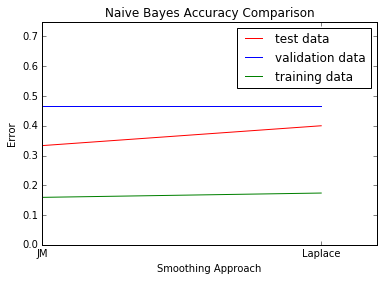

In [3]:
 %matplotlib inline
#HW 1.4.2    
import numpy as np
import matplotlib.pyplot as plt

with open("EnronModelCompare.txt") as f:
    data = f.read()

data = data.split('\n')


x = [row.split('\t')[0] for row in data]
x = map(lambda q:1.0 if q == "JM" else 2.0,x)

y = [row.split('\t')[4] for row in data]
y = map(float,y)

test_x = [x[0], x[1]]
test_y = [y[0], y[1]]

validation_x = [x[2],x[3]]
validation_y = [y[2], y[3]]

train_x = [x[4], x[5]]
train_y = [y[4], y[5]]



my_xticks = ['JM', 'Laplace']


plt.plot(test_x, test_y, 'r', label='test data')
plt.plot(test_x, validation_y, 'b', label='validation data')
plt.plot(test_x, train_y, 'g', label='training data')
plt.title("Naive Bayes Accuracy Comparison")
plt.xticks(test_x, my_xticks)
plt.xlabel('Smoothing Approach')
plt.ylabel('Error')
plt.legend()
plt.ylim(0.0,0.75)


plt.show()


Based on the error rates in the training, testing and validation sets, the Jelinek-Mercer smoothing appears to perform better than Laplace smoothing for Naive Bayes

## HW1.5: Remove words with frequency of less than three (3) in the training set

#### Repeat HW1.4. This time when modeling and classification ignore tokens with a frequency of less than three (3) in the training set. How does it affect the misclassifcation error of learnt naive multinomial Bayesian Classifier on the training dataset. Report the error and the change in error. HINT: ignore tokens with a frequency of less than three (3). Think of this as a preprocessing step. How many new mapreduce jobs do you need to solve thus homework?

In [18]:
%%writefile EnronNaiveBayesTrainerLaplace3W.py
#HW 1.5
from mrjob.job import MRJob
import sys, re, string, operator

regex = re.compile('[%s]' % re.escape(string.punctuation))

class EnronNaiveBayesTrainerLaplace3W(MRJob):
    
    def __init__(self, *args, **kwargs):
        super(EnronNaiveBayesTrainerLaplace3W, self).__init__(*args, **kwargs)
        self.modelStats = {}

    def jobconf(self):
        orig_jobconf = super(EnronNaiveBayesTrainerLaplace3W, self).jobconf()        
        custom_jobconf = {
            'mapred.output.key.comparator.class': 'org.apache.hadoop.mapred.lib.KeyFieldBasedComparator',
            'mapred.text.key.comparator.options': '-k1rn',
            'mapred.reduce.tasks': '1',
        }
        combined_jobconf = orig_jobconf
        combined_jobconf.update(custom_jobconf)
        self.jobconf = combined_jobconf
        return combined_jobconf

    def mapper(self, _, line):
        # Don't actually yield anything for each line. Instead, collect them
        # and yield the sums when all lines have been processed. The results
        # will be collected by the reducer.
        docID, docClass,text = line.split("\t",2) 
        text = text.strip()
        text = regex.sub(' ', text.lower())
        text = re.sub( '\s+', ' ', text )
        words = text.split()
        
        if docClass == "1":
            yield("TomsPriors", "0,1")
            for word in words:
                if len(word) > 2:
                    yield(word, "0,1")
        else:
            yield("TomsPriors", "1,0")
            for word in words:
                if len(word) > 2:
                    yield(word, "1,0")
        

    def reducer(self, word, values):
        #aggregate counts for Pr(Word|Class)
        #yield("number of values for "+word, str(values))
        w0Total=0
        w1Total=0
        for value in values:
            w0, w1 =  value.split(",")
            w0Total += float(w0)
            w1Total += float(w1)  
        self.modelStats[word] =  [w0Total, w1Total]

        #yield("JIMI "+word, [w0Total, w1Total])
    def reducer_final(self):       
        class0Total = 0
        class1Total = 0
        for k in self.modelStats.keys():
            if k != "TomsPriors":
                class0Total += self.modelStats[k][0]
                class1Total += self.modelStats[k][1]
        vocabularySize = len(self.modelStats.keys()) -1  #ignore TomsPriors
        #some yields to see some model internal parameters
        #yield ("defaultPrior 0 class", class0Total+vocabularySize)
        #yield ("defaultPrior 1 class", class1Total+vocabularySize)
        #yield ("count 0 class", class0Total)
        #yield ("count 1 class", class1Total)
        #yield ("vocabularySize", vocabularySize)
        
        #calculate priors 
        classCount0, classCount1 = self.modelStats.get("TomsPriors")
        del self.modelStats["TomsPriors"]
        total = classCount0 + classCount1
        yield("TomsPriors", ','.join(str(j) for j in [classCount0, classCount1, classCount0/total, classCount1/total])) 
        for k in self.modelStats.keys():
            yield(k, ','.join(str(j) for j in [self.modelStats[k][0],
                      self.modelStats[k][1],                       
                      (self.modelStats[k][0] + 1) /(class0Total + vocabularySize), 
                      (self.modelStats[k][1] +1)/(class1Total+vocabularySize)]))                   
        #print(self.modelStats["assistance"])
        #print(vocabularySize)
        #print(class0Total, class1Total)
# The if __name__ == "__main__": 
# ... trick exists in Python so that our Python files 
# can act as either reusable modules, or as standalone programs.

if __name__ == '__main__':
    EnronNaiveBayesTrainerLaplace3W.run(),
                                               

Overwriting EnronNaiveBayesTrainerLaplace3W.py


In [12]:
%%writefile EnronNaiveBayesTrainerJM3W.py
#HW 1.5
from mrjob.job import MRJob
import sys, re, string, operator

regex = re.compile('[%s]' % re.escape(string.punctuation))

class EnronNaiveBayesTrainerJM3W(MRJob):
    
    def __init__(self, *args, **kwargs):
        super(EnronNaiveBayesTrainerJM3W, self).__init__(*args, **kwargs)
        self.modelStats = {}

    def jobconf(self):
        orig_jobconf = super(EnronNaiveBayesTrainerJM3W, self).jobconf()        
        custom_jobconf = {
            'mapred.output.key.comparator.class': 'org.apache.hadoop.mapred.lib.KeyFieldBasedComparator',
            'mapred.text.key.comparator.options': '-k1rn',
            'mapred.reduce.tasks': '1',
        }
        combined_jobconf = orig_jobconf
        combined_jobconf.update(custom_jobconf)
        self.jobconf = combined_jobconf
        return combined_jobconf

    def mapper(self, _, line):
        # Don't actually yield anything for each line. Instead, collect them
        # and yield the sums when all lines have been processed. The results
        # will be collected by the reducer.
        docID, docClass,text = line.split("\t",2) 
        text = text.strip()
        text = regex.sub(' ', text.lower())
        text = re.sub( '\s+', ' ', text )
        words = text.split()
        
        if docClass == "1":
            yield("TomsPriors", "0,1")
            for word in words:
                if len(word) > 2:
                    yield(word, "0,1")
        else:
            yield("TomsPriors", "1,0")
            for word in words:
                if len(word) > 2:
                    yield(word, "1,0")
        

    def reducer(self, word, values):
        #aggregate counts for Pr(Word|Class)
        #yield("number of values for "+word, str(values))
        w0Total=0
        w1Total=0
        for value in values:
            w0, w1 =  value.split(",")
            w0Total += float(w0)
            w1Total += float(w1)  
        self.modelStats[word] =  [w0Total, w1Total]

        #yield("JIMI "+word, [w0Total, w1Total])
    def reducer_final(self):       
        class0Total = 0
        class1Total = 0
        JM = .3
        for k in self.modelStats.keys():
            if k != "TomsPriors":
                class0Total += self.modelStats[k][0]
                class1Total += self.modelStats[k][1]
        vocabularySize = len(self.modelStats.keys()) -1  #ignore TomsPriors
        #some yields to see some model internal parameters
        #yield ("defaultPrior 0 class", class0Total+vocabularySize)
        #yield ("defaultPrior 1 class", class1Total+vocabularySize)
        #yield ("count 0 class", class0Total)
        #yield ("count 1 class", class1Total)
        #yield ("vocabularySize", vocabularySize)
        print(class0Total, class1Total)
        #calculate priors 
        classCount0, classCount1 = self.modelStats.get("TomsPriors")
        del self.modelStats["TomsPriors"]
        total = classCount0 + classCount1
        yield("TomsPriors", ','.join(str(j) for j in [classCount0, classCount1, classCount0/total, classCount1/total])) 
        for k in self.modelStats.keys():
            yield(k, ','.join(str(j) for j in [self.modelStats[k][0],
                      self.modelStats[k][1],                       
                      (((1-JM)*(self.modelStats[k][0]/class0Total)) + (JM *(self.modelStats[k][0] + self.modelStats[k][1])/(class0Total + class1Total))), 
                      (((1-JM)*(self.modelStats[k][1]/class1Total)) + JM *(self.modelStats[k][0] + self.modelStats[k][1])/(class0Total + class1Total))]))
                            
        #print(self.modelStats["assistance"])
        #print(vocabularySize)
        
# The if __name__ == "__main__": 
# ... trick exists in Python so that our Python files 
# can act as either reusable modules, or as standalone programs.

if __name__ == '__main__':
    EnronNaiveBayesTrainerJM3W.run(),
                                               

Writing EnronNaiveBayesTrainerJM3W.py


In [20]:
%%writefile EnronNaiveBayesClassifierLaplace3W.py
#HW 1.5
 
from mrjob.job import MRJob
import sys, re, string, operator, math, os


regex = re.compile('[%s]' % re.escape(string.punctuation))

class EnronNaiveBayesClassifierLaplace3W(MRJob):


    def __init__(self, *args, **kwargs):
        super(EnronNaiveBayesClassifierLaplace3W, self).__init__(*args, **kwargs)
        
    def jobconf(self):
        orig_jobconf = super(EnronNaiveBayesClassifierLaplace3W, self).jobconf()        
        custom_jobconf = {
            'mapred.output.key.comparator.class': 'org.apache.hadoop.mapred.lib.KeyFieldBasedComparator',
            'mapred.text.key.comparator.options': '-k1rn',
            'mapred.reduce.tasks': '1',
        }
        combined_jobconf = orig_jobconf
        combined_jobconf.update(custom_jobconf)
        self.jobconf = combined_jobconf
        return combined_jobconf    

    #load model from file; it has been sent from the master node to each worker node
    def mapper_init(self):
        self.modelStats = {}
        recordStrs = [s.split('\n')[0].split('\t') for s in open("EnronModelLaplace_train3W.txt").readlines()]
        for word, statsStr in recordStrs:
            self.modelStats[word] = map(float, statsStr.split(","))
        
        self.prC0 = math.log(self.modelStats["TomsPriors"][2])
        self.prC1 = math.log(self.modelStats["TomsPriors"][3])
        

    
    def mapper(self, _, line):
        
        docID, docClass,text = line.split("\t",2)
        text = text.strip()
        text = regex.sub(' ', text.lower())
        text = re.sub( '\s+', ' ', text )
        words = text.split()
        
        for word in words:
            if len(word) > 2:
                if word in self.modelStats:
                    p0 = self.modelStats[word][2]
                    p1 = self.modelStats[word][3]
                    wordGivenHam = math.log(p0) if p0>0.0 else math.log(1)
                    wordGivenSpam = math.log(p1) if p1>0.0 else math.log(1)
                    prHAMGivenDoc = self.prC0 + wordGivenHam
                    prSPAMGivenDoc = self.prC1 + wordGivenSpam
                else: 
                    wordGivenHam = math.log(1)
                    wordGivenSpam = math.log(1)
                    prHAMGivenDoc = self.prC0 + wordGivenHam
                    prSPAMGivenDoc = self.prC1 + wordGivenSpam    
        
        predictedClass = 1 #SPAM
        if(prHAMGivenDoc > prSPAMGivenDoc):
            predictedClass = 0 #HAM
        if int(docClass) == predictedClass:
            yield (docID, 0)  #no error
        else: 
            yield (docID, 1) # error    
     
    def combiner(self, word, values):
        for value in values:
            yield ("t", value)
            
    def reducer(self, word, values):      
        numberOfRecords = 0
        numberWrong = 0
        for value in values:
            numberOfRecords += 1
            numberWrong += value
        #print (numberOfRecords, numberWrong)
        otpt = str(numberOfRecords) + "\t" +  str(numberWrong) + "\t" + str((1.0*numberWrong)/(1.0*numberOfRecords))
        yield ("Laplace",otpt)
        #print ('Error rate: %.4f' %(1.0*numberWrong/float(numberOfRecords)))
        #print ('Number Wrong %d, Total Records %d'  %(numberWrong, numberOfRecords))
        



if __name__ == '__main__':
    EnronNaiveBayesClassifierLaplace1.run()

Overwriting EnronNaiveBayesClassifierLaplace3W.py


In [21]:
%%writefile EnronNaiveBayesClassifierJM3W.py
#HW 1.5
 
from mrjob.job import MRJob
import sys, re, string, operator, math, os


regex = re.compile('[%s]' % re.escape(string.punctuation))

class EnronNaiveBayesClassifierJM3W(MRJob):


    def __init__(self, *args, **kwargs):
        super(EnronNaiveBayesClassifierJM3W, self).__init__(*args, **kwargs)
        
    def jobconf(self):
        orig_jobconf = super(EnronNaiveBayesClassifierJM3W, self).jobconf()        
        custom_jobconf = {
            'mapred.output.key.comparator.class': 'org.apache.hadoop.mapred.lib.KeyFieldBasedComparator',
            'mapred.text.key.comparator.options': '-k1rn',
            'mapred.reduce.tasks': '1',
        }
        combined_jobconf = orig_jobconf
        combined_jobconf.update(custom_jobconf)
        self.jobconf = combined_jobconf
        return combined_jobconf    

    #load model from file; it has been sent from the master node to each worker node
    def mapper_init(self):
        self.modelStats = {}
        recordStrs = [s.split('\n')[0].split('\t') for s in open("EnronModelJM_train3W.txt").readlines()]
        for word, statsStr in recordStrs:
            self.modelStats[word] = map(float, statsStr.split(","))
        
        self.prC0 = math.log(self.modelStats["TomsPriors"][2])
        self.prC1 = math.log(self.modelStats["TomsPriors"][3])
        

    
    def mapper(self, _, line):
        
        docID, docClass,text = line.split("\t",2)
        text = text.strip()
        text = regex.sub(' ', text.lower())
        text = re.sub( '\s+', ' ', text )
        words = text.split()
        
        for word in words:
            if len(word) > 2:
                if word in self.modelStats:
                    p0 = self.modelStats[word][2]
                    p1 = self.modelStats[word][3]
                    wordGivenHam = math.log(p0) if p0>0.0 else math.log(1)
                    wordGivenSpam = math.log(p1) if p1>0.0 else math.log(1)
                    prHAMGivenDoc = self.prC0 + wordGivenHam
                    prSPAMGivenDoc = self.prC1 + wordGivenSpam
                else: 
                    wordGivenHam = math.log(1)
                    wordGivenSpam = math.log(1)
                    prHAMGivenDoc = self.prC0 + wordGivenHam
                    prSPAMGivenDoc = self.prC1 + wordGivenSpam
        
        predictedClass = 1 #SPAM
        if(prHAMGivenDoc > prSPAMGivenDoc):
            predictedClass = 0 #HAM
        if int(docClass) == predictedClass:
            yield (docID, 0)  #no error
        else: 
            yield (docID, 1) # error    
     
    def combiner(self, word, values):
        for value in values:
            yield ("t", value)
            
    def reducer(self, word, values):      
        numberOfRecords = 0
        numberWrong = 0
        for value in values:
            numberOfRecords += 1
            numberWrong += value
        otpt = str(numberOfRecords) + "\t" +  str(numberWrong) + "\t" + str((1.0*numberWrong)/(1.0*numberOfRecords))    
        yield ("JM",otpt)
        #print ('Error rate: %.4f' %(1.0*numberWrong/float(numberOfRecords)))
        #print ('Number Wrong %d, Total Records %d'  %(numberWrong, numberOfRecords))
        



if __name__ == '__main__':
    EnronNaiveBayesClassifierJM3W.run()



Overwriting EnronNaiveBayesClassifierJM3W.py


In [22]:
%reload_ext autoreload
%autoreload 2

#HW 1.5

from numpy import random
from EnronNaiveBayesTrainerJM3W import EnronNaiveBayesTrainerJM3W
from EnronNaiveBayesClassifierJM3W import EnronNaiveBayesClassifierJM3W
from EnronNaiveBayesTrainerLaplace3W import EnronNaiveBayesTrainerLaplace3W
from EnronNaiveBayesClassifierLaplace3W import EnronNaiveBayesClassifierLaplace3W

# Train Models     
#, '--file=EnronModelJM_train3W.txt'
mr_job = EnronNaiveBayesTrainerJM3W(args=['train.txt'])  #--file=model.txt is for the classifier
modelStats={}
with mr_job.make_runner() as runner: 
    runner.run()
        # stream_output: get access of the output 
    for line in runner.stream_output():
        key,value =  mr_job.parse_output_line(line)
        #print key, value
        modelStats[key] = value
        
        #Store the model locally
        # Update the centroids for the next iteration
    with open('EnronModelJM_train3W.txt', 'w') as f:
        for k in modelStats.keys():
            f.writelines( k + "\t"+ str(modelStats[k]) +"\n")
            

#, '--file=EnronModelLaplace_train3W.txt'
mr_job = EnronNaiveBayesTrainerLaplace3W(args=['train.txt'])  #--file=model.txt is for the classifier
modelStats={}
with mr_job.make_runner() as runner: 
    runner.run()
        # stream_output: get access of the output 
    for line in runner.stream_output():
        key,value =  mr_job.parse_output_line(line)
        #print key, value
        modelStats[key] = value
        
        #Store the model locally
        # Update the centroids for the next iteration
    with open('EnronModelLaplace_train3W.txt', 'w') as f:
        for k in modelStats.keys():
            f.writelines( k + "\t"+ str(modelStats[k]) +"\n")
            
#Classify!
# STEP 2: Classify data with newly trained model      
mr_job = EnronNaiveBayesClassifierJM3W(args=['test.txt', '--file=EnronModelJM_train3W.txt'])  #call the data and the model
with mr_job.make_runner() as runner:
    runner.run()
    for line in runner.stream_output():
        data_set = "test"
        key,value =  mr_job.parse_output_line(line)
        with open("EnronModelCompare3W.txt", 'w') as q:
            q.writelines(key + "\t" + data_set + "\t" + value + "\n")
            
            
            
# STEP 2: Classify data with newly trained model      
mr_job = EnronNaiveBayesClassifierLaplace3W(args=['test.txt', '--file=EnronModelLaplace_train3W.txt'])  #call the data and the model
with mr_job.make_runner() as runner:
    runner.run()
    #for line in runner.stream_output():
    for line in runner.stream_output():
        data_set = "test"
        key,value =  mr_job.parse_output_line(line)
        with open("EnronModelCompare3W.txt", 'a') as q:
            q.writelines(key + "\t" + data_set + "\t" + value + "\n")

            
#Validation
            
          
# STEP 2: Classify data with newly trained model      
mr_job = EnronNaiveBayesClassifierJM3W(args=['validation.txt', '--file=EnronModelJM_train3W.txt'])  #call the data and the model
with mr_job.make_runner() as runner:
    runner.run()
    for line in runner.stream_output():
        data_set = "validation"
        key,value =  mr_job.parse_output_line(line)
        with open("EnronModelCompare3W.txt", 'a') as q:
            q.writelines(key + "\t" + data_set + "\t" + value + "\n")            
        
        

            
# STEP 2: Classify data with newly trained model      
mr_job = EnronNaiveBayesClassifierLaplace3W(args=['validation.txt', '--file=EnronModelLaplace_train3W.txt'])  #call the data and the model
with mr_job.make_runner() as runner:
    runner.run()
    #for line in runner.stream_output():
    for line in runner.stream_output():
        data_set = "validation"
        key,value =  mr_job.parse_output_line(line)
        with open("EnronModelCompare3W.txt", 'a') as q:
            q.writelines(key + "\t" + data_set + "\t" + value + "\n")

            
#Train
            
            
# STEP 2: Classify data with newly trained model      
mr_job = EnronNaiveBayesClassifierJM3W(args=['train.txt', '--file=EnronModelJM_train3W.txt'])  #call the data and the model
with mr_job.make_runner() as runner:
    runner.run()
    for line in runner.stream_output():
        data_set = "train"
        key,value =  mr_job.parse_output_line(line)
        with open("EnronModelCompare3W.txt", 'a') as q:
            q.writelines(key + "\t" + data_set + "\t" + value + "\n")            
    

            
# STEP 2: Classify data with newly trained model      
mr_job = EnronNaiveBayesClassifierLaplace3W(args=['train.txt', '--file=EnronModelLaplace_train3W.txt'])  #call the data and the model
with mr_job.make_runner() as runner:
    runner.run()
    #for line in runner.stream_output():
    for line in runner.stream_output():
        data_set = "train"
        key,value =  mr_job.parse_output_line(line)
        with open("EnronModelCompare3W.txt", 'a') as q:
            q.writelines(key + "\t" + data_set + "\t" + value)            

(6932.0, 12607.0)


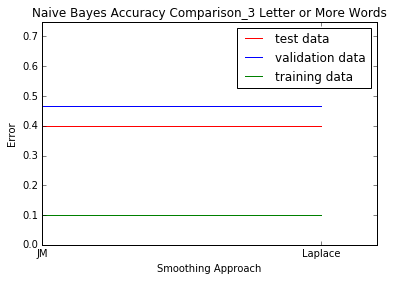

In [23]:
 %matplotlib inline
#HW 1.5    
import numpy as np
import matplotlib.pyplot as plt

with open("EnronModelCompare3W.txt") as f:
    data = f.read()

data = data.split('\n')


x = [row.split('\t')[0] for row in data]
x = map(lambda q:1.0 if q == "JM" else 2.0,x)

y = [row.split('\t')[4] for row in data]
y = map(float,y)

test_x = [x[0], x[1]]
test_y = [y[0], y[1]]

validation_x = [x[2],x[3]]
validation_y = [y[2], y[3]]

train_x = [x[4], x[5]]
train_y = [y[4], y[5]]



my_xticks = ['JM', 'Laplace']


plt.plot(test_x, test_y, 'r', label='test data')
plt.plot(test_x, validation_y, 'b', label='validation data')
plt.plot(test_x, train_y, 'g', label='training data')
plt.title("Naive Bayes Accuracy Comparison_3 Letter or More Words")
plt.xticks(test_x, my_xticks)
plt.xlabel('Smoothing Approach')
plt.ylabel('Error')
plt.legend()
plt.ylim(0.0,0.75)


plt.show()


Excluding words with less than 3 letters didn't seem to reduce the model error with either Laplace smoothing or Jelinek-Mercer smoothing.  However, both models performed a lot better on the training set.  Given that, I think the test and validation set error could be a case of small sample sizes.  I did not need any new MapReduce steps to remove the words under 3 letters.  It was a couple lines of code.

I also researched whether it was best to ignore the words in the trainer only or in the trainer and classifier both.  I found that you need to ignore the words in both otherwise the model yields higher error.

## HW1.6 Benchmark your code with the Python SciKit-Learn implementation of the multinomial Naive Bayes algorithm

#### In this exercise, please complete the following:

####  Run the Multinomial Naive Bayes algorithm (using default settings) from SciKit-Learn over the same training data used in HW1.4.2 and report the misclassification error (please note some data preparation might be needed to get the Multinomial Naive Bayes algorithm from SkiKit-Learn to run over this dataset)
####  Prepare a table to present your results, where rows correspond to approach used (SkiKit-Learn versus your Hadoop implementation) and the column presents the  misclassification error rates (train, validation, testing)
####  Explain/justify any differences in terms of training error rates over the dataset in HW1.5 between your Multinomial Naive Bayes implementation (in Map Reduce) versus the Multinomial Naive Bayes implementation in SciKit-Learn


In [101]:
#HW 1.6
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix, f1_score
from pandas import DataFrame
import numpy as np
import re, string

regex = re.compile('[%s]' % re.escape(string.punctuation))

data_set = open("train.txt", 'r')
rows = []
index = []
scores = []
confusion = np.array([[0, 0],[0, 0]])
train_scores = []
train_confusion = np.array([[0, 0],[0, 0]])
validation_scores = []
validation_confusion = np.array([[0, 0], [0, 0]])

model = MultinomialNB()

for line in data_set:
    docID, docClass,text = line.split("\t",2)
    text = text.strip()
    text = regex.sub(' ', text.lower())
    text = re.sub( '\s+', ' ', text )
    rows.append({'text': text, 'class': docClass})
    index.append(docID)

    data_frame = DataFrame(rows, index=index)

data = data_frame.reindex(np.random.permutation(data_frame.index))    
#print(data_frame)    
    
count_vectorizer = CountVectorizer()
counts = count_vectorizer.fit_transform(data['text'].values)

targets = data['class'].values
model.fit(counts, targets)

train_predictions = model.predict(counts)
train_confusion += confusion_matrix(targets, train_predictions)
train_score = f1_score(targets, train_predictions, pos_label='1')
train_scores.append(train_score)
print('Train Score:', sum(train_scores)/len(train_scores))
print('Train Confusion Matrix:')
print(train_confusion)


#Test Data
test_set = open("test.txt", 'r')
test_rows = []
test_index = []

for line in test_set:
    testID, testClass,testText = line.split("\t",2)
    testText = testText.strip()
    testText = regex.sub(' ', testText.lower())
    testText = re.sub( '\s+', ' ', testText )
    test_rows.append({'text': testText, 'class': testClass})
    test_index.append(testID)

    test_frame = DataFrame(test_rows, index = test_index)

test_data = test_frame.reindex(np.random.permutation(test_frame.index))
test_counts = count_vectorizer.transform(test_data['text'].values)
test_targets = test_data['class'].values
test_predictions = model.predict(test_counts)

confusion += confusion_matrix(test_targets, test_predictions)
score = f1_score(test_targets, test_predictions, pos_label='1')
scores.append(score)

print('Test Score:', sum(scores)/len(scores))
print('Test Confusion Matrix:')
print(confusion)



#Validation Data
validation_set = open("validation.txt", 'r')
validation_rows = []
validation_index = []

for lines in validation_set:
    validationID, validationClass, validationText = line.split("\t", 2)
    validationText = validationText.strip()
    validationText = regex.sub(' ', validationText.lower())
    validationText = re.sub( '\s+', ' ', validationText )
    validation_rows.append({'text': validationText, 'class': validationClass})
    validation_index.append(validationID)

    validation_frame = DataFrame(validation_rows, index = validation_index)

validation_data = validation_frame.reindex(np.random.permutation(validation_frame.index))
validation_counts = count_vectorizer.transform(validation_data['text'].values)
validation_targets = validation_data['class'].values
validation_predictions = model.predict(validation_counts)

validation_confusion += confusion_matrix(validation_targets, validation_predictions)
validation_score = f1_score(validation_targets, validation_predictions, pos_label='1')
validation_scores.append(validation_score)

print('Validation Score:', sum(validation_scores)/len(validation_scores))
print('Validation Confusion Matrix:')
print(validation_confusion)

#print(test_list)    
    
#examples = ['Free Viagra call today!', "I'm going to attend the Linux users group tomorrow."]
#example_counts = count_vectorizer.transform(examples)
#predictions = model.predict(example_counts)
#predictions # [1, 0]
#print(example_counts)




('Train Score:', 1.0)
Train Confusion Matrix:
[[38  0]
 [ 0 31]]
('Test Score:', 0.87500000000000011)
Test Confusion Matrix:
[[6 2]
 [0 7]]
('Validation Score:', 1.0)
Validation Confusion Matrix:
[[15 15]
 [15 15]]


Jimi, this was a big time stretch problem.  It took a long time to get working due to having no knowledge on the data config needed for sklearn!

The correct classification errors are above.  The test data error appears to be ~50% lower than the error of my model.  The validation set outputs from sklearn look screwy.

## HW 1.6.1: OPTIONAL (note this exercise is a stretch HW and optional)

#### Run the Bernoulli Naive Bayes algorithm from SciKit-Learn (using default settings) over the same training data used in HW1.6 and report the misclassification error

In [102]:
#HW 1.6.1
from sklearn.naive_bayes import BernoulliNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix, f1_score
from pandas import DataFrame
import numpy as np
import re, string

regex = re.compile('[%s]' % re.escape(string.punctuation))

data_set = open("train.txt", 'r')
rows = []
index = []
scores = []
confusion = np.array([[0, 0],[0, 0]])
train_scores = []
train_confusion = np.array([[0, 0],[0, 0]])
validation_scores = []
validation_confusion = np.array([[0, 0], [0, 0]])

model = BernoulliNB()

for line in data_set:
    docID, docClass,text = line.split("\t",2)
    text = text.strip()
    text = regex.sub(' ', text.lower())
    text = re.sub( '\s+', ' ', text )
    rows.append({'text': text, 'class': docClass})
    index.append(docID)

    data_frame = DataFrame(rows, index=index)

data = data_frame.reindex(np.random.permutation(data_frame.index))    
#print(data_frame)    
    
count_vectorizer = CountVectorizer()
counts = count_vectorizer.fit_transform(data['text'].values)

targets = data['class'].values
model.fit(counts, targets)

train_predictions = model.predict(counts)
train_confusion += confusion_matrix(targets, train_predictions)
train_score = f1_score(targets, train_predictions, pos_label='1')
train_scores.append(train_score)
print('Train Score:', sum(train_scores)/len(train_scores))
print('Train Confusion Matrix:')
print(train_confusion)


#Test Data
test_set = open("test.txt", 'r')
test_rows = []
test_index = []

for line in test_set:
    testID, testClass,testText = line.split("\t",2)
    testText = testText.strip()
    testText = regex.sub(' ', testText.lower())
    testText = re.sub( '\s+', ' ', testText )
    test_rows.append({'text': testText, 'class': testClass})
    test_index.append(testID)

    test_frame = DataFrame(test_rows, index = test_index)

test_data = test_frame.reindex(np.random.permutation(test_frame.index))
test_counts = count_vectorizer.transform(test_data['text'].values)
test_targets = test_data['class'].values
test_predictions = model.predict(test_counts)

confusion += confusion_matrix(test_targets, test_predictions)
score = f1_score(test_targets, test_predictions, pos_label='1')
scores.append(score)

print('Test Score:', sum(scores)/len(scores))
print('Test Confusion Matrix:')
print(confusion)



#Validation Data
validation_set = open("validation.txt", 'r')
validation_rows = []
validation_index = []

for lines in validation_set:
    validationID, validationClass, validationText = line.split("\t", 2)
    validationText = validationText.strip()
    validationText = regex.sub(' ', validationText.lower())
    validationText = re.sub( '\s+', ' ', validationText )
    validation_rows.append({'text': validationText, 'class': validationClass})
    validation_index.append(validationID)

    validation_frame = DataFrame(validation_rows, index = validation_index)

validation_data = validation_frame.reindex(np.random.permutation(validation_frame.index))
validation_counts = count_vectorizer.transform(validation_data['text'].values)
validation_targets = validation_data['class'].values
validation_predictions = model.predict(validation_counts)

validation_confusion += confusion_matrix(validation_targets, validation_predictions)
validation_score = f1_score(validation_targets, validation_predictions, pos_label='1')
validation_scores.append(validation_score)

print('Validation Score:', sum(validation_scores)/len(validation_scores))
print('Validation Confusion Matrix:')
print(validation_confusion)

#print(test_list)    
    
#examples = ['Free Viagra call today!', "I'm going to attend the Linux users group tomorrow."]
#example_counts = count_vectorizer.transform(examples)
#predictions = model.predict(example_counts)
#predictions # [1, 0]
#print(example_counts)




('Train Score:', 0.55813953488372092)
Train Confusion Matrix:
[[38  0]
 [19 12]]
('Test Score:', 0.44444444444444448)
Test Confusion Matrix:
[[8 0]
 [5 2]]
('Validation Score:', 1.0)
Validation Confusion Matrix:
[[15 15]
 [15 15]]


Bernoulli Naive Bayes did not seem to do nearly as well for the Spam filter as Multinomial.  Error rates were worse than the model I built and much worse than the sklearn multinomial model.  I would recommend Multinomial Naive Bayes for Spam detection vs Bernoulli